# Import dependancies

In [38]:
import os, re
import pandas as pd
import numpy as np
from summarise.io import doc_to_csv
from summarise.io import pdf_to_text_file
from summarise.preprocess import cleaner, tokeniser, remove_whitespace, clean_text, clean_tokens, find_references
from summarise.visualise import plot_wordcloud, plot_histogram, count_document_tokens, count_tokens, highlight_entities, count_entities
from summarise.model import KeywordTextRank, SentenceTextRank

In [39]:
# Helper functions
def write_text_to_file( text, filename ):
    """Writes text to file"""
    with open( filename, "w", encoding="utf-8") as f:    
        f.write( text )
        f.close()

# Fetch raw data

In [40]:
# Define constants
ROOT            = os.path.abspath('') #current directory
DATA_FOLDER     = os.path.join( ROOT, 'data')
IMG_FOLDER      = os.path.join( ROOT, 'img')
OUTPUT_FOLDER   = os.path.join( ROOT, 'output')
ALL_DATA        = os.path.join( DATA_FOLDER, 'all_data.csv' )
if os.path.isfile( ALL_DATA ):
    # Read pre-processed data
    df          = pd.read_csv( ALL_DATA )
else:
    # Create from scratch
    filenames   = pdf_to_text_file( DATA_FOLDER )
    df          = doc_to_csv( filenames, ALL_DATA )
df.head()

,Unnamed: 0,Name,Text
0,0,cyborg-supervision-speech-by-james-proudman.txt,\r\n\r\n \r\n \r\n \r\n \r\n \r\n \r\n \r\n \...
1,1,managing-machines-the-governance-of-artificial...,\r\n\r\n \r\n \r\n \r\n \r\n \r\n \r\n \r\n \...
2,2,supervisor-centred-automation-the-role-of-huma...,\r\n\r\n \r\n \r\n \r\n \r\n \r\n \r\n \r\n \...


# Pre-processing

In [41]:
documents   = df['Text'].values.tolist()
token_list  = [tokeniser( clean_text(doc), allowed_postags=['NOUN','PROPN', 'VERB'] ) for doc in documents]

# Exploratory Analysis / Feature Engineering

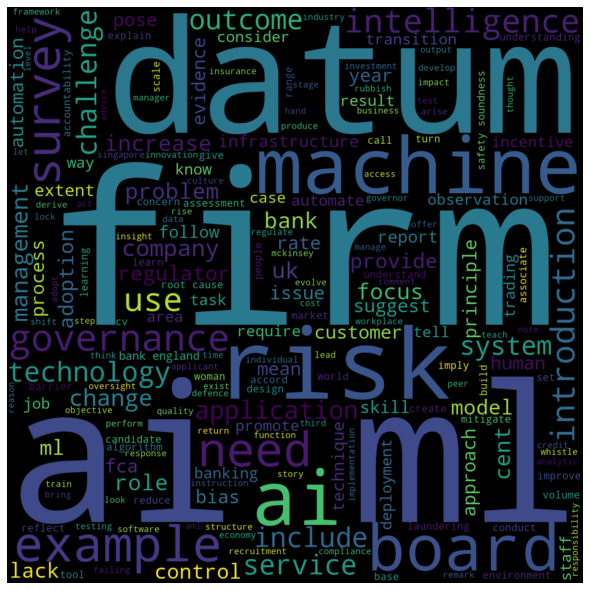

In [42]:
# Word cloud
filename    = ""
# Uncomment below to save file
#filename    = os.path.join( IMG_FOLDER, 'wordcloud.png')
plt         = plot_wordcloud(token_list[1],"",filename=filename)

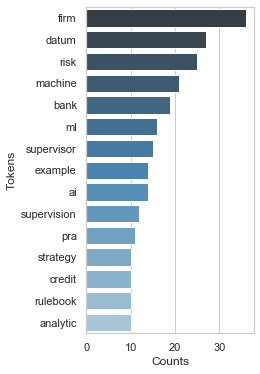

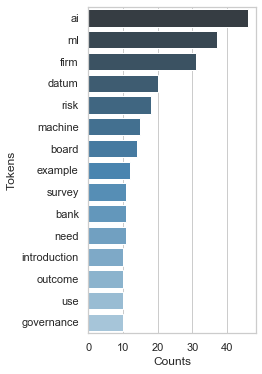

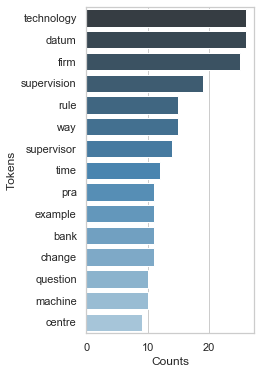

In [43]:
# Word frequency
plts = [plot_histogram( tokens, filename=os.path.join( IMG_FOLDER, 'histogram{:02d}.png'.format(i)) ) for i, tokens in enumerate(token_list)]


In [44]:
# Document frequency
token_counts_df = count_document_tokens(token_list)
token_counts_df.columns=['Document 1','Document 2','Document 3']
token_counts_df.head(25)

,Document 1,Document 2,Document 3
firm,36.0,31.0,25.0
datum,27.0,20.0,26.0
risk,25.0,18.0,8.0
machine,21.0,15.0,10.0
bank,19.0,11.0,11.0
ml,16.0,37.0,NaN
supervisor,15.0,1.0,14.0
example,14.0,12.0,11.0
ai,14.0,46.0,3.0
supervision,12.0,1.0,19.0


In [45]:
# Save DF to file
filename = os.path.join( OUTPUT_FOLDER, "tokens_frequency.csv" )
token_counts_df.to_csv( filename )
print("Written files")

Written files


In [46]:
# Count tokens
all_tokens = []
for tokens in token_list:
    all_tokens = all_tokens + tokens
all_tokens_count_df = count_tokens(all_tokens)
print("Number of unique tokens = {}".format(len(all_tokens_count_df.index)))
print("Number of tokens = {}".format(len(all_tokens)))

Number of unique tokens = 1060
Number of tokens = 3613


In [47]:
# Entity Analysis
highlight_entities( remove_whitespace( documents[2], False ), 20 )

In [48]:
entities_df = count_entities( clean_text(documents[2]) )
entities_df.head(20)


,Counts
Tokens,
PRA,9
Bank of England,5
BigBank,5
SmallBank,4
prudential,2
AI,1
Small Bank,1
Sholthana Begum,1
Shoib Khan,1


In [49]:
# Save entities to file
for i, doc in enumerate(documents):
    entities_df = count_entities( clean_text( doc ) )
    filename = os.path.join( OUTPUT_FOLDER, "entities{:02d}.csv".format(i) )
    entities_df.to_csv( filename )
print("Written files")

Written files


In [50]:
# Print references
refs = find_references(documents[2])
for r in refs:
    print(r)


26 March 2020 

1 Or whatever device we are using by then. 

2 “Cyborg supervision – the application of advanced analytics in prudential supervision” 19 November 2018 

3 “New economy, new finance, new Bank”, speech by Mark Carney, 21 June 2018 

4 Bank of England Discussion Paper, 7 January 2020 

5 “Credit union meets robot”, speech by Sam Woods, 24 October 2019 


In [51]:
# Save references to file
for i, doc in enumerate(documents):
    refs        = find_references(doc)
    text        = "".join(refs)
    filename    = os.path.join( OUTPUT_FOLDER, "extracted_references{:02d}.txt".format(i) )
    write_text_to_file( text, filename )
print("Written files")

Written files


# Modelling

In [52]:
# Import sklearn classes
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline

In [53]:
# Feature engineering - bag of words
bow_vector      = CountVectorizer( 
                        tokenizer = tokeniser,
                        token_pattern='[a-zA-Z0-9]{3,}', # num chars > 3                       
                        ngram_range=(1,1), #only consider unigrams
                        max_features=500,
                        max_df=0.75 #exclude tokens that occur in >75% of the corpus
                        )

In [54]:
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
# Number of topics
number_topics = 3
# Create LDA model
lda = LDA( 
        n_components = number_topics, 
        n_jobs=-1, 
        random_state=42
        )
# Create pipeline using Bag of Words
pipe = Pipeline([('cleaner', cleaner()),
                 ('vectoriser', bow_vector),
                 ('reduce_dim', lda)])
# Data
X = df['Text'].values.tolist()

In [55]:
# Optimise hyperparameters
from sklearn.model_selection import GridSearchCV
# Define Search Param
search_params = {'reduce_dim__learning_decay': [.5, .7, .9], 'reduce_dim__doc_topic_prior': [.01, .1, .3], 'reduce_dim__topic_word_prior': [.01, .1, .3]}
# Initialise the Model
search = GridSearchCV( pipe, param_grid = search_params, cv=3, n_jobs=-1 )

In [56]:
# Do the Grid Search
search.fit(X)
# Return best parameter set
search.best_params_

In [57]:
results = pd.DataFrame(search.cv_results_)
results.head()

In [58]:
# Create LDA model with optimal parameters
lda = LDA( 
        n_components = number_topics, 
        n_jobs=-1, 
        random_state=42,
        learning_decay=0.5,
        doc_topic_prior=0.01,
        topic_word_prior=0.3
        )
# Create pipeline using Bag of Words
pipe = Pipeline([('cleaner', cleaner()),
                 ('vectoriser', bow_vector),
                 ('reduce_dim', lda)])

In [59]:
# Fit model
pipe.fit(X)
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
# Print the topics found by the LDA model
number_words = 10 
print("Topics found via LDA:")
print_topics(pipe[2], pipe[1], number_words)

Topics found via LDA:

Topic #0:
survey governance use company cent control adoption infrastructure suggest bias

Topic #1:
supervisory use supervision letter rulebook part supervise research tool analyse

Topic #2:
supervision question centre advance objective code real regulated able know


In [60]:
# Create Document — Topic Matrix
def topic_matrix(pipe, X):    
    lda_output  = pipe.transform(X)# column names
    topicnames  = ["Topic" + str(i) for i in range(pipe[2].n_components)]# index names
    docnames    = ["Doc" + str(i) for i in range(len(X))]# Make the pandas dataframe
    df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames,index=docnames)    # Get dominant topic for each document
    dominant_topic = np.argmax(df_document_topic.values, axis=1)
    df_document_topic["dominant_topic"] = dominant_topic
    return df_document_topic
df_document_topic = topic_matrix(pipe, X)

In [61]:
df_document_topic

,Topic0,Topic1,Topic2,dominant_topic
Doc0,0.0,1.0,0.0,1
Doc1,1.0,0.0,0.0,0
Doc2,0.0,0.0,1.0,2


# Summarisation

In [62]:
# Data
X       = df['Text'].values.tolist()
rank    = SentenceTextRank()

In [63]:
# Run sentence ranking
ranked_sentences = []
for doc in X:
    text                = clean_text( doc )
    ranked_sentences.append( rank.analyse( text ) )

In [64]:
# Extract top 10 sentences as the summary
for i in range(10):
  print(ranked_sentences[2][i][1])

Advances in technology are rapidly changing both the world around us, and our ability to analyse those changes – through the application of increased computing power to mixed structured and unstructured data sets and text - freeing up time for the forward-looking, judgement-based supervision, which is where the true value add of supervision lies.
A more strategic approach, however, is likely to prove necessary to make a reality of a longer-term goal of embedding technology at the heart of how prudential risks are supervised – that is, not simply identifying applications in supervision that would benefit from technology, but fundamentally re-engineering the way we work.
At the extreme, there is the “pull” model of data collection, implicitly described in the example I used in the introduction to these remarks - in which regulators would be able to pull data, at any level of granularity, directly from firms’ systems in real time, with no intervention on the part of firms.
In the case of 

In [65]:
# Save results to file
sentence_range = range(10) # top 10 sentences
for i, doc in enumerate(ranked_sentences):
    text        = '\n'.join([doc[k][1].text for k in sentence_range])
    filename    = os.path.join( OUTPUT_FOLDER, "ranked_summary{:02d}.txt".format(i) )
    write_text_to_file( text, filename )
print('Written files')

Written files


In [66]:
# Keyword ranking
text    = clean_text( X[0] )
rank    = KeywordTextRank()
rank.analyse(text, candidate_pos = ['NOUN', 'PROPN'], window_size=4, lower=False)
rank.get_keywords(15)

firms - 9.722346341054514
data - 9.656338783814203
AI - 5.247863262340851
example - 5.086196630287295
risks - 4.6510325402511645
supervision - 4.47421399859781
machine - 4.275408478763415
ML - 4.100325298741722
supervisors - 4.063882026654413
PRA - 3.814425245760945
credit - 3.8057468470637694
analytics - 3.6630978867988744
time - 3.3752541990251275
banks - 2.942914992174678
J. - 2.94244819023569
information - 2.908015852679802
risk - 2.907500842661083
